In [1]:
import autoencoder.adversarial as aae
import autoencoder.utils as utils 
import autoencoder.cluster_layer as clay

import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline


/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
config = tf.ConfigProto(
        device_count = {'GPU': 0})

esize = [(64,3), (128, 3), (256,3)]
dsize = list(reversed(esize))

params =dict()

params['nclusters'] = 10
params['width'] = 32
params['height'] = 32
params['nchannels'] = 4
params['channels'] = [0, 1,3,4]
params['nepochs'] = 20
params['batchsize'] = 256
params['learning_rate'] = 0.0005
params['restore'] = False
params['latent_size'] = 256
params['enc_sizes'] = esize 
params['dec_sizes'] = dsize
params['droprate'] = 0.85
params['stdev'] = 0.04
params['denoise'] = False
params['slam'] = 0

datadir = "/media/cjw/Data/cyto/mmCompensatedTifs/"
cpf = "/media/cjw/Data/cyto/Checkpoints/2018-09-13-12-41-19_idec_try_3/"
cpf += "checkpoint-2018-09-13-12-41-19/autoencoder-256x-80000"
#cpf += "checkpoint-2018-09-12-11-01-37/autoencoder-16x-40000"
cpd = ""

In [3]:
rl = aae.aae_loader(params, datadir, cpf, cpd)

In [4]:
rl.load()


Encoder True
Tensor("Placeholder:0", shape=(?, 32, 32, 4), dtype=float32) (?, 32, 32, 4)
isize:  4 32
dh0 (?, 32, 32, 4)
[<tf.Variable 'encoder/filter_00/kernel:0' shape=(3, 3, 4, 64) dtype=float32_ref>, <tf.Variable 'encoder/filter_00/bias:0' shape=(64,) dtype=float32_ref>, <tf.Variable 'encoder/filter_01/kernel:0' shape=(3, 3, 64, 128) dtype=float32_ref>, <tf.Variable 'encoder/filter_01/bias:0' shape=(128,) dtype=float32_ref>, <tf.Variable 'encoder/filter_02/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>, <tf.Variable 'encoder/filter_02/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'encoder/latent_space/kernel:0' shape=(4096, 256) dtype=float32_ref>, <tf.Variable 'encoder/latent_space/bias:0' shape=(256,) dtype=float32_ref>, <tf.Variable 'decoder/dense/kernel:0' shape=(256, 4096) dtype=float32_ref>, <tf.Variable 'decoder/dense/bias:0' shape=(4096,) dtype=float32_ref>, <tf.Variable 'decoder/conv2d_transpose/kernel:0' shape=(3, 3, 128, 256) dtype=float32_ref>, <tf.Variable

In [5]:
#cluster = clay.cluster_train(rl)

In [25]:
sdf = rl.df.sample(10000)

b = utils.get_df(rl.mmdict, sdf, 32, 4, [0,1,3,4])

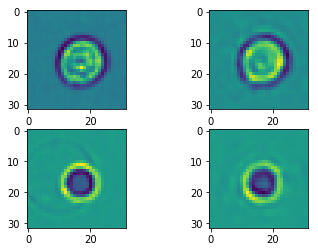

In [26]:
z = rl.encoder.eval({rl.images:b}, session=rl.sess)
dc = rl.decoder.eval({rl.encoder:z}, session=rl.sess)

index = 0
c = 0
dr = np.squeeze(dc[index,:,:,c])
plt.subplot(2,2,1)
plt.imshow(b[index,:,:,c])
plt.subplot(2,2,2)
plt.imshow(dr)

dr = np.squeeze(dc[index + 1,:,:,c])
plt.subplot(2,2,3)
plt.imshow(b[index + 1,:,:,c])
plt.subplot(2,2,4)
plt.imshow(dr)

In [113]:
import numpy as np
res = cluster.eval({rl.images:b}, session = rl.sess)


In [114]:
n19 = (np.argmax(res, axis=1) == 14)
ni = np.where(n19)[0]
print(len(ni))

17


In [11]:
nr = len(ni)
if nr > 12:
    nr = 12
nc = 1
plt.figure(figsize=(8,nr*4))
for ie, i in enumerate(ni):
    #print(i)
    plt.subplot(nr,4,nc)
    nc +=1
    plt.imshow(b[i,:,:,0])
    
    if ie >= 11:
        print(ie)
        break
    
    
    

NameError: name 'ni' is not defined

[   0    0    0    0    0    0    0    0    0    0 9213  787    0    0
    0    0    0    0    0    0] [-10.  -9.  -8.  -7.  -6.  -5.  -4.  -3.  -2.  -1.   0.   1.   2.   3.
   4.   5.   6.   7.   8.   9.  10.]


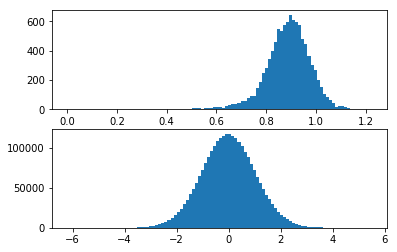

In [27]:
from scipy.spatial.distance import cdist

pz = np.expand_dims(1*z[0],0)

pzdc = rl.decoder.eval({rl.encoder:pz}, session=rl.sess)
pzcd = cdist(z, pz, 'correlation')
zasort = np.argsort(pzcd, axis=0)

plt.subplot(2,1,1)
hz, hzx = np.histogram(pzcd, bins=20,range=(-10,10))
print(hz, hzx)
plt.hist(pzcd, bins=100)
plt.subplot(2,1,2)
_ = plt.hist(np.reshape(z, (-1)), bins=100)

In [135]:
def tdist(x1, x2):
    y = x1 - x2
    y = 1 + np.sum(y*y)
    y = 1./y
    return 256*y
    
    
def ndist(x1, x2):
    y = x1 - x2
    y = np.sum(y*y)
    y =np.exp(-y/2.)
    return y

from scipy.spatial.distance import cdist

zi = 3071
ztest = np.random.normal(0,2, (256))
p1 = np.expand_dims(z[zi],0)

pdc = rl.decoder.eval({rl.encoder:p1}, session=rl.sess)
pcd = cdist(z, p1, 'euclidean')#'chebyshev')

asort = np.argsort(pcd, axis=0)
#asort = np.flip(np.argsort(pcd, axis=0), 0)
tps = asort[0:100,0]
bps = np.flip(asort[-99:,0], 0)
pcd[tps[0:8]],  pcd[bps[-8:]], '\n', tps[0:8]


(array([[ 0.        ],
        [11.78080493],
        [11.84192971],
        [12.37097118],
        [12.81315392],
        [12.89945877],
        [13.02381052],
        [13.12336602]]), array([[25.37433169],
        [25.35384578],
        [25.35343523],
        [25.35166975],
        [25.32981575],
        [25.32510865],
        [25.31206564],
        [25.30704184]]), '\n', array([3071, 2022, 6434, 3804, 5946, 2265,  383, 1735]))

In [200]:
from sklearn.cluster import DBSCAN
dbs = DBSCAN(.4, 7, metric='correlation', n_jobs=-1)
db = dbs.fit_predict(z)


In [286]:
from sklearn.cluster import AgglomerativeClustering, mean_shift, AffinityPropagation, KMeans
#ac = AgglomerativeClustering(24).fit_predict(z)
#apc = AffinityPropagation()
#ap = apc.fit_predict(z)
kms = KMeans(32,n_init=40, max_iter=5000, tol=1e-7, n_jobs=-1)
km = kms.fit_predict(z)

In [291]:
from sklearn.cluster import SpectralClustering
scc = SpectralClustering( n_jobs=-1)
sc = scc.fit_predict(z)

KeyboardInterrupt: 

In [269]:
print(len(set(km)))
sdf['ac'] = ac
sdf['ap'] = ap
sdf['km'] = km
sdf['sc'] = sc
print(np.histogram(km, bins=24))


24
(array([280, 182, 396, 180, 592, 454, 291, 646, 663, 631, 390, 146, 418,
       487, 258, 572, 253, 445, 421, 330, 571, 469, 501, 424]), array([ 0.        ,  0.95833333,  1.91666667,  2.875     ,  3.83333333,
        4.79166667,  5.75      ,  6.70833333,  7.66666667,  8.625     ,
        9.58333333, 10.54166667, 11.5       , 12.45833333, 13.41666667,
       14.375     , 15.33333333, 16.29166667, 17.25      , 18.20833333,
       19.16666667, 20.125     , 21.08333333, 22.04166667, 23.        ]))


280 11


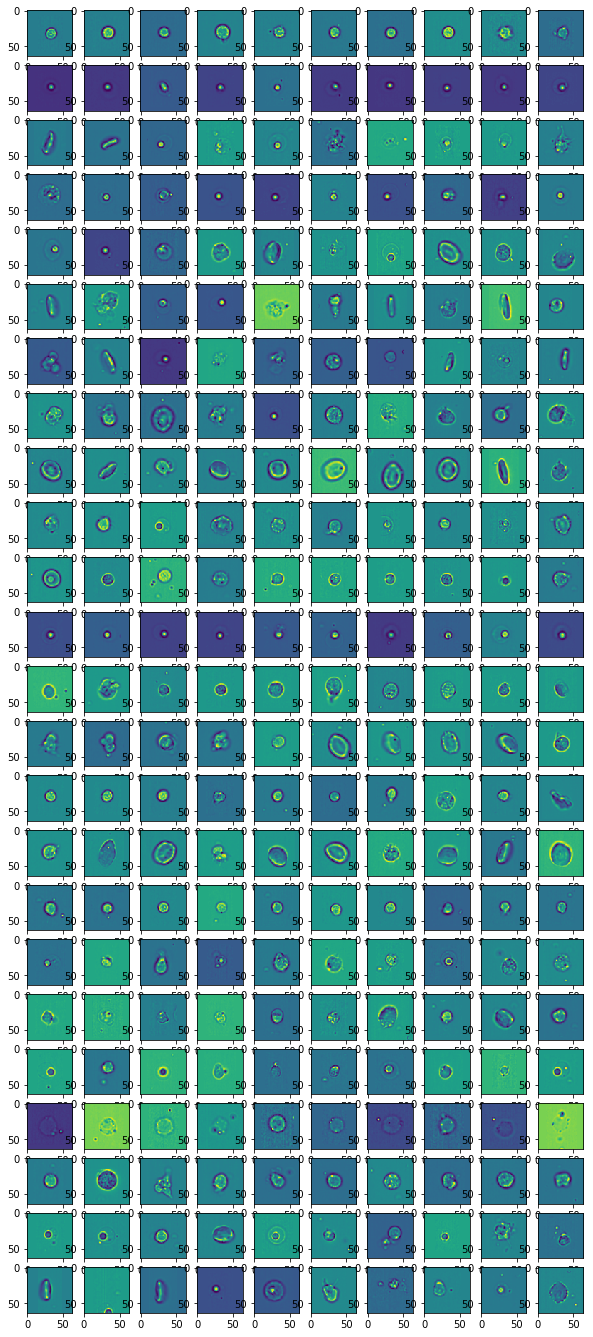

In [287]:
a = sdf[sdf['km'] == 0]
#print(len(a), len(set(dbs.labels_)))
# print(a.iloc[0].index)
# print(sdf.iloc[0].index)
# print(a.head())
#print(rl.mmdict.keys())

pi = 1
plt.figure(figsize=(10,32))
for n in range(len(set(km))):
    a = sdf[sdf['km'] == n]
    for i in range(len(a)):
        row = a.iloc[i]
        fid = row['fid']
        mm = row['mmfile']
        kk = rl.mmdict[mm][fid]
        plt.subplot(len(set(km)),10,pi)
        pi += 1
        plt.imshow(kk[:,:,0])
        if i >= 9:
            break

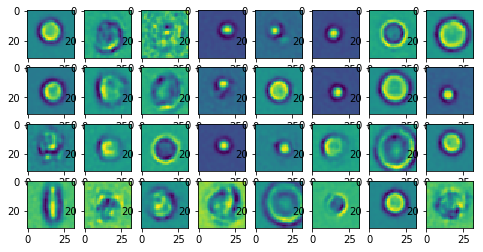

In [288]:
centers = kms.cluster_centers_
plt.figure(figsize=(8,4))
pi = 1
for center in centers:
    center = np.expand_dims(center, 0)
    dcent = rl.decoder.eval({rl.encoder:center}, session=rl.sess)
    plt.subplot(4, 8, pi)
    pi += 1
    plt.imshow(dcent[0,:,:,0])

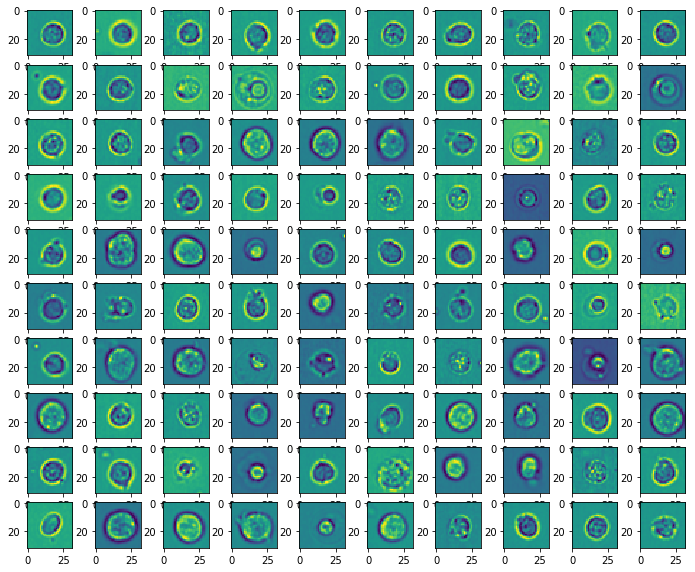

In [122]:
nc = 1
nr = len(tps)//4 + 1
plt.figure(figsize=(12,nr))
plt.subplot(nr,10,nc)
nc +=1
plt.imshow(np.squeeze(b[zi,:,:,0])) #b[zi,:,:,0])
#plt.imshow(np.squeeze(pdc[0, :,:,0])) #b[zi,:,:,0])    
for ie, i in enumerate(tps):
    if ie == 0:
        continue
    plt.subplot(nr,10,nc)
    nc +=1
    plt.imshow(b[i,:,:,0])
    

    

(100, 32, 32, 4)


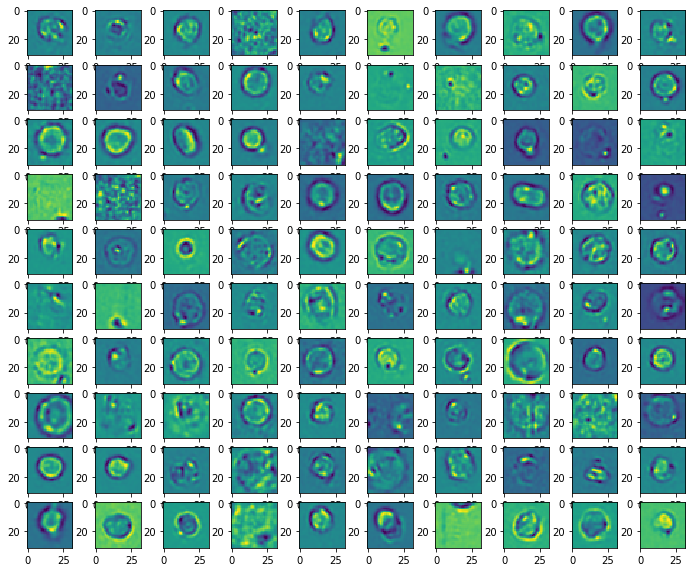

In [40]:
fdc = rl.decoder.eval({rl.encoder:z[tps]}, session=rl.sess)

print(fdc.shape)
plt.figure(figsize=(12,nr))
# plt.subplot(nr,10,nc)
# nc +=1
# plt.imshow(np.squeeze(b[zi,:,:,0])) #b[zi,:,:,0])
nc = 1    
for ie, i in enumerate(tps):
    if ie == -1:
        continue
    plt.subplot(nr,10,nc)
    nc +=1
    plt.imshow(fdc[ie,:,:,0])

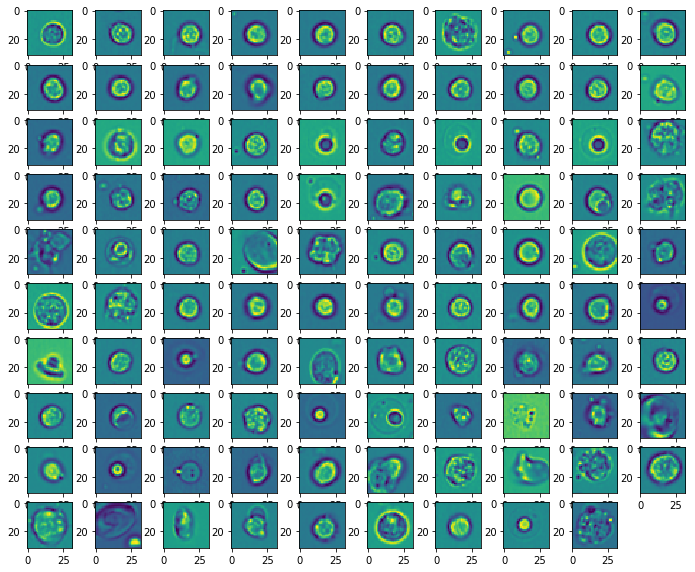

In [123]:
nc = 1
nr = len(tps)//4 + 1
plt.figure(figsize=(12,nr))
plt.subplot(nr,10,nc)
nc +=1
plt.imshow(b[zi,:,:,0])
    
for ie, i in enumerate(bps):
    if ie == 0:
        continue
    plt.subplot(nr,10,nc)
    nc +=1
    plt.imshow(b[i,:,:,0])

In [159]:
from sklearn.manifold import TSNE
zsn = np.random.permutation(np.linspace(0, len(z-1), num=len(z), dtype=np.int32))
zs = z[zsn[0:6000]]
tsne = TSNE(2, 90,learning_rate=50 ,metric='correlation').fit_transform(zs)

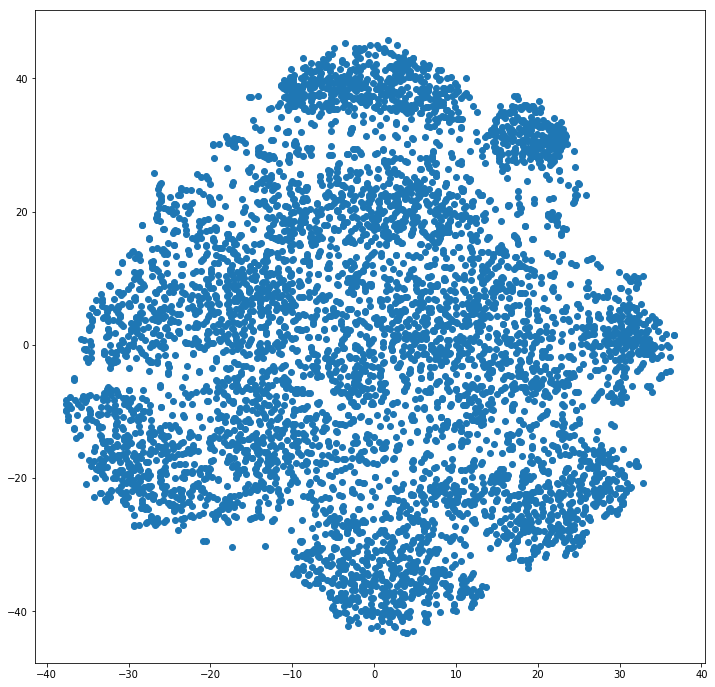

In [160]:
plt.figure(figsize=(12,12))
plt.scatter(tsne[:,0], tsne[:,1])

In [ ]:
np.linalg.norm(np.array([1,2,-3]), ord=2, axis=0)
#qv

In [ ]:
from scipy.spatial.distance import euclidean
wgh = rl.sess.run(cluster.weights)
wgh = wgh[0]

for p in z:
    print(np.linalg.norm(wgh[16] - p, ord=2))


In [ ]:
from scipy.signal import convolve

zi = np.copy(z[index:index+2])
#zi = np.expand_dims(zi, 0)
zi = -zi[0]# + zi[1]
#zi = convolve(zi, np.array([1])/1, mode='same')
#zi[np.abs(zi) < .5] *= 0
rx = np.random.randint(0, 256, 10)
#zi[rx] = 10
#zi = np.sum(zi, axis=0)/2
zi = np.expand_dims(zi, 0)
plt.plot(zi[0])
zi.shape

In [ ]:
di = rl.decoder.eval({rl.encoder:zi}, session=rl.sess)
plt.imshow(np.squeeze(di[0,:,:,0]))